## ML Classification
Uses previously obtained number of GM, WM, & CSF pixels to train a logistic-regression classifier to find relationship between GM, WM, CSF and age

### Import Libraries & Pathing

In [1]:
from pathlib import Path
import os
import os.path as op
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# Scikit-learn
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report, make_scorer, balanced_accuracy_score, fbeta_score, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
nl = '\n' # For f-string formatting

In [2]:
## Pathing
path = '../'

images_path = Path(path, 'data', 'images')
masks_path = Path(path, 'data', 'masks')
segs_path = Path(path, 'data', 'segs_refs')
metadata_path = Path(path, 'data', 'meta')

## Preparing Data for Classification

In [3]:
## Reading in data from CSV file
    # Make sure to run Get "brain data.ipynb" first to generate the CSV file
data_table = pd.read_csv(Path(path, 'data', 'brain_data_code.csv'))
data_table.head()

,subject,age,gender,CSF,GM,WM
0,CC110033,24,1,32255,88877,53097
1,CC110037,18,1,23522,93552,53059
2,CC110045,24,2,22655,97481,49497
3,CC110056,22,2,20673,86147,49316
4,CC110062,20,1,20466,110771,60077


In [4]:
# Extracting X - a 2D matrix of features (Gray matter, white matter, & CSF pixels)
X = data_table[['GM', 'WM', 'CSF']].values

# Extracting Y - a 1D array of labels (age)
y = data_table[['age', 'gender']].values

# Confirming shape of X and Y match
print(f"X:{X[:3]}{nl}Y:{y[:3]}")
print(f"Shapes are: {nl}X: {X.shape} Y: {y.shape}")

X:[[88877 53097 32255]
 [93552 53059 23522]
 [97481 49497 22655]]
Y:[[24  1]
 [18  1]
 [24  2]]
Shapes are: 
X: (652, 3) Y: (652, 2)


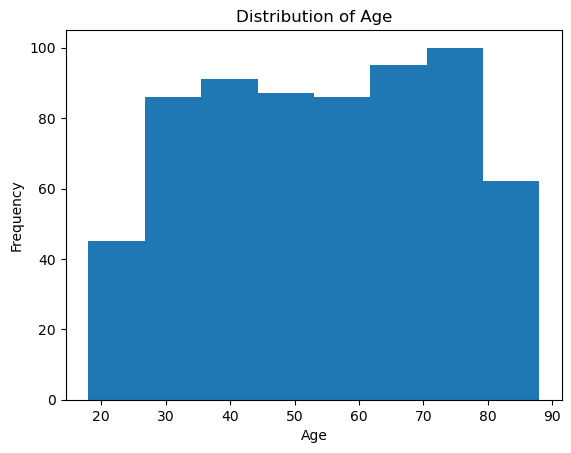

In [5]:
# Looking at age distribution to find the best way to binarize the age variable
plt.hist(y[:,0], bins=8)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

In [6]:
# Age Binning 
    # 0 = 15-24, 1 = 25-34, 2 = 35-44, 3 = 45-54, 4 = 55-64, 5 = 65-74, 6 = 75-84, 7 = 85+
bins = np.array([15, 25, 35, 45, 55, 65, 75, 85])

# Bin the age along the first axis of y
y_binned = np.digitize(y[:,0], bins)

# Use the LabelEncoder to fit and transform the binned ages
le = LabelEncoder()
y_encoded = le.fit_transform(y_binned)

# Recombining the binned age array with participant genders
y_encoded = np.hstack((y_encoded.reshape(-1,1), y[:,1].reshape(-1,1)))

# Check to make sure y_encoded matches y
equal = np.array_equal(y[:, 1], y_encoded[:, 1])

print(f'Genders in y_encoded and y match: {equal}')

Genders in y_encoded and y match: True


## Machine Learning Classification
Uses a logistic regression classifier to find relationship between age and GM, WM, & CSF

In [21]:
## Make Train and Test Splits
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_encoded,
                                                    stratify=y_encoded,
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True
                                                    )
print(f"Shapes of Train and Test splits: {nl}X_train: {X_train.shape} X_test: {X_test.shape} y_train: {y_train.shape} y_test: {y_test.shape}")

Shapes of Train and Test splits: 
X_train: (521, 3) X_test: (131, 3) y_train: (521, 2) y_test: (131, 2)


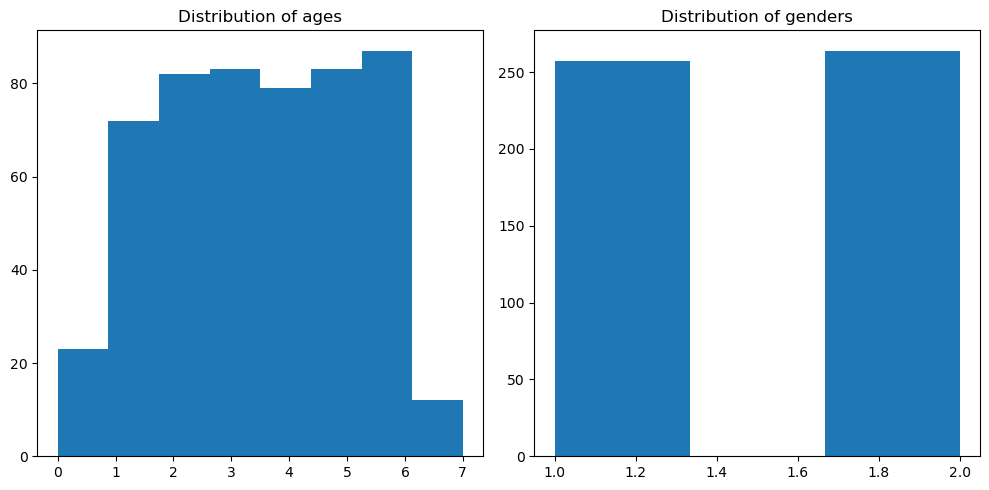

In [22]:
## Visualizing if stratifying for ages & genders was successful
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot ages on the first subplot
axs[0].hist(y_train[:,0], bins=8)
axs[0].set_title('Distribution of ages')

# Plot genders on the second subplot
axs[1].hist(y_train[:,1], bins=3)
axs[1].set_title('Distribution of genders')

plt.tight_layout()
plt.show()

In [23]:
## Removing gender axis after stratification 
    # We don't want the classifier to train using gender as a feature
y_train = y_train[:,0]
y_test = y_test[:,0]
print(f'New shapes of y_train and y_test: {nl}y_train: {y_train.shape} y_test: {y_test.shape}')

New shapes of y_train and y_test: 
y_train: (521,) y_test: (131,)


In [24]:
scoring = {'Prec': make_scorer(precision_score, zero_division=0),
           'Bal_Acc': make_scorer(balanced_accuracy_score),
           'Acc': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score),
           'ROC': make_scorer(roc_auc_score),
           'Matthews_Coef': make_scorer(matthews_corrcoef),
           'Fbeta_0.5': make_scorer(fbeta_score, beta = 0.5),
           'Fbeta_1.5': make_scorer(fbeta_score, beta = 1.5),
           'F1_score': make_scorer(f1_score, zero_division=0)
          }

Training Classifier
Predicting...
Scoring...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.58      0.83      0.68        18
           2       0.46      0.57      0.51        21
           3       0.44      0.33      0.38        21
           4       0.54      0.35      0.42        20
           5       0.46      0.60      0.52        20
           6       0.70      0.73      0.71        22
           7       0.00      0.00      0.00         3

    accuracy                           0.53       131
   macro avg       0.40      0.43      0.40       131
weighted avg       0.49      0.53      0.50       131



c:\Users\masci\.conda\envs\neuro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\masci\.conda\envs\neuro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\masci\.conda\envs\neuro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


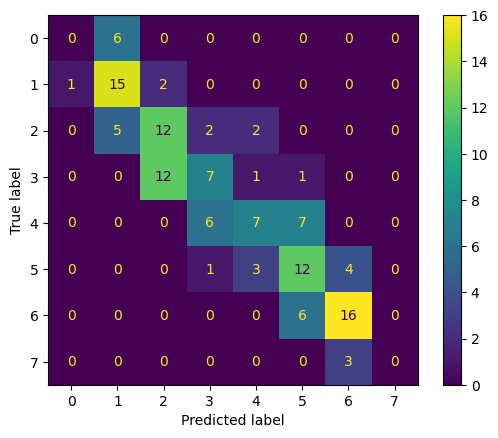

In [26]:
scaler = StandardScaler() # Should be PCA instead?  https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
#vectorizer = Vectorizer()

log_reg = LogisticRegression(max_iter=10000, tol=0.1, multi_class='auto') # Hyperparameters to be tuned


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


clf = Pipeline([#('Vectorizer', vectorizer),
                ('Scaler', scaler), # Should be PCA instead?
                ('logistic', log_reg)                                 
                ])

# Cross validating
cv_cv = cross_validate(clf, X_train, y_train, 
                        cv=cv,
 #                       scoring=scoring,
                        return_train_score=True, # Determines if Training scores are included in .cv_results_
                        n_jobs=-1,
                        error_score='raise' # For debugging purposes
                        )

print('Training Classifier')
clf = clf.fit(X_train, y_train)

print('Predicting...')
y_pred = clf.predict(X_test)

print('Scoring...')        
print(classification_report(y_test, y_pred))

# Confusion Matrix Generation and Visualization within the loop -> saved to csv as "[[TN, FN] [FP, TP]]"
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cmd.plot()
plt.show()

# Saving CV results to a  DataFrame 
#results = pd.DataFrame(cv_cv)



### Visualizing Results